In [1]:
import os
import os.path
import glob
import numpy as np
import Image,leargist
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
imagedir = "Datasets/Detection/Byteplots"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
X = np.zeros((num_samples, 320))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        im = Image.open(img_file)
        im1 = im.resize((64,64),Image.ANTIALIAS); # for faster computation
        des = leargist.color_gist(im1)
        X[cnt] = des[0:320]
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:          Banker	Number of images: 1986
Label: 1	Family:          WinExe	Number of images: 1945
Processing images ...


/usr/local/lib/python2.7/dist-packages/PIL/Image.py:2371: DecompressionBombWarning: Image size (103265280 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/usr/local/lib/python2.7/dist-packages/PIL/Image.py:2371: DecompressionBombWarning: Image size (110601216 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Images processed: 3931


In [4]:
# Create stratified k-fold subsets
kfold = 5  # no. of folds
skf = StratifiedKFold(kfold, shuffle=True, random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0
for index in skf.split(X, y):
    skfind[cnt] = index
    cnt += 1

In [5]:
# Supervised Classification with k-fold Cross Validation
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]

    clf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
    clf.fit(X_train,y_train)  # Training
    y_predict = clf.predict(X_test)  # Testing
    print("[%d] Test acurracy: %.4f" %(i,accuracy_score(y_test,y_predict)))
    cm = confusion_matrix(y_test,y_predict)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

[0] Test acurracy: 0.8437
[1] Test acurracy: 0.8193
[2] Test acurracy: 0.8626
[3] Test acurracy: 0.8626
[4] Test acurracy: 0.8359


In [6]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.8448


Plotting the confusion matrix


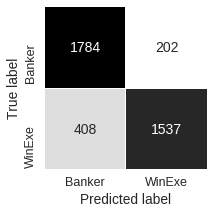

In [7]:
import seaborn as sns

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(5, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 14}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


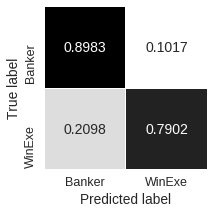

In [8]:
import seaborn as sns

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1,keepdims=True)  # Normalizing the confusion matrix

figure = plt.gcf()
figure.set_size_inches(5, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.4f', annot_kws={'size': 14}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()